In [164]:
from ultralytics import YOLO
import random, cv2, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import config

# --- load model ---
model = YOLO(config.LANE_MODEL)

from quadrilateral_fitter import QuadrilateralFitter


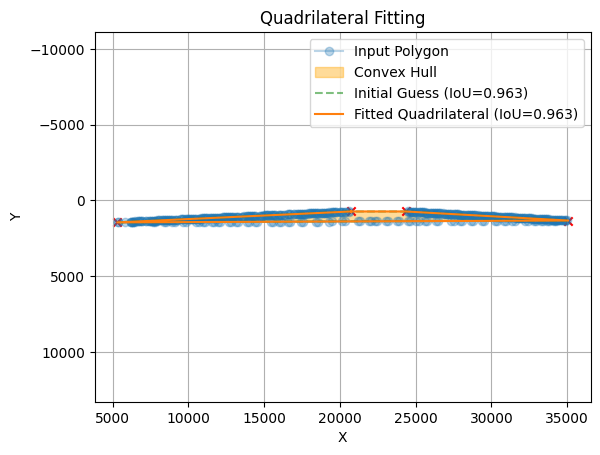

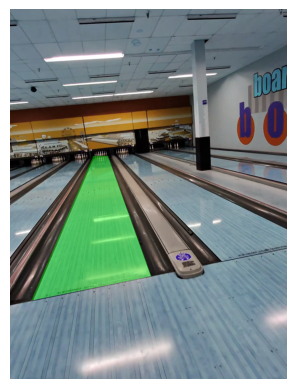

In [182]:
SCALE = 50  

# --- pick random image ---
img_paths = list(Path("data/raw_frames/new").glob("*.png"))
img_path = random.choice(img_paths)

# --- load image ---
img = cv2.imread(str(img_path))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# --- inference ---
res = model.predict(source=str(img_path), conf=0.25, verbose=False)[0]

# --- get polygon ---
polygon = res.masks.xy[0]

polygon = polygon.copy()
polygon[:, 0] *= SCALE # scale x axis (quad fitter struggles with narrow shapes)


fitter = QuadrilateralFitter(polygon)
fitted_quadrilateral = np.array(fitter.fit(), dtype=np.float32)
fitter.plot()

# h, w = img.shape[:2]
# mask = np.zeros((h, w), dtype=np.uint8)

quad = np.array(fitter.fit(), dtype=np.float32)
quad[:, 0] /= SCALE

quad = quad.astype(np.int32)

overlay = img.copy()

cv2.fillPoly(overlay, [quad], (0, 255, 0))

alpha = 0.4
blended = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)

blended = cv2.resize(blended, None, fx=0.5, fy=0.5)
plt.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()



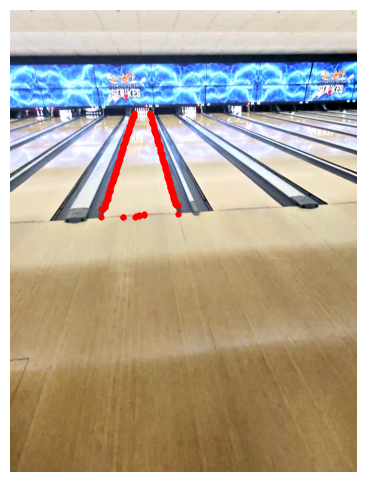

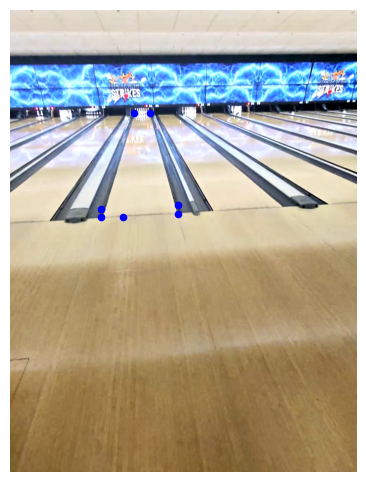

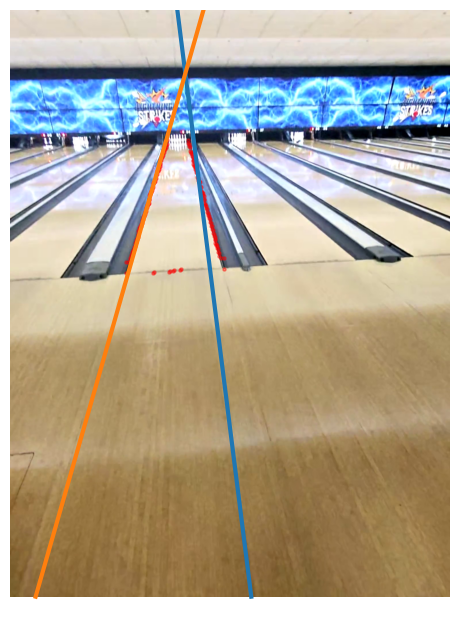

In [114]:

from scipy.spatial import ConvexHull

# --- pick random image ---
img_paths = list(Path("data/raw_frames/new").glob("*.png"))
img_path = random.choice(img_paths)

# --- load image ---
img = cv2.imread(str(img_path))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# --- inference ---
res = model.predict(source=str(img_path), conf=0.25, verbose=False)[0]

# --- get probability mask ---
prob = res.masks.data[0].cpu().numpy()   # float32 [0,1]

# --- get polygon ---
polygon = res.masks.xy[0]

plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.scatter(polygon[:, 0], polygon[:, 1], s=10, c="red")

plt.scatter(polygon[:, 0], polygon[:, 1], s=10, c="red")
plt.axis("off")
plt.show()
plt.show()

# ---- compute convex hull ----
hull = ConvexHull(polygon)
hull_pts = polygon[hull.vertices]

# bl br tl tr

# split top vs bottom using y
idx = np.argsort(hull_pts[:, 1])
top = hull_pts[idx[:2]]
bottom = hull_pts[idx[-2:]]

# split left vs right using x
TL = top[np.argmin(top[:, 0])]
TR = top[np.argmax(top[:, 0])]
BL = bottom[np.argmin(bottom[:, 0])]
BR = bottom[np.argmax(bottom[:, 0])]

corners = np.array([TL, TR, BR, BL])



# ---- FIGURE 2: hull only ----
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.scatter(hull_pts[:, 0], hull_pts[:, 1], s=20, c="blue")

plt.axis("off")
plt.show()

hull_pts[:, 0] # x pts
hull_pts[:, 1] # y pts

import numpy as np
import cv2

pts = polygon.astype(np.float32)  # (N, 2)

# --- 1. PCA to find lane direction ---
mean = pts.mean(axis=0)
pts_centered = pts - mean

_, _, Vt = np.linalg.svd(pts_centered)
direction = Vt[0]              # principal axis
normal = np.array([-direction[1], direction[0]])

# --- 2. Project points onto normal to split left/right ---
proj = pts_centered @ normal

left_pts  = pts[proj < 0]
right_pts = pts[proj > 0]

# --- 3. Fit line (total least squares) ---
def fit_line(points):
    m = points.mean(axis=0)
    _, _, Vt = np.linalg.svd(points - m)
    d = Vt[0]
    return m, d   # point + direction

l_pt, l_dir = fit_line(left_pts)
r_pt, r_dir = fit_line(right_pts)

import matplotlib.pyplot as plt

def line_xy(p, d, y_min, y_max):
    ys = np.array([y_min, y_max])
    xs = p[0] + (ys - p[1]) * d[0] / d[1]
    return xs, ys

h = img.shape[0]

lx, ly = line_xy(l_pt, l_dir, 0, h)
rx, ry = line_xy(r_pt, r_dir, 0, h)

plt.figure(figsize=(6, 8))
plt.imshow(img)
plt.scatter(pts[:, 0], pts[:, 1], s=5, c="red", alpha=0.4)

plt.plot(lx, ly, linewidth=3)   # left line
plt.plot(rx, ry, linewidth=3)   # right line

plt.axis("off")
plt.show()



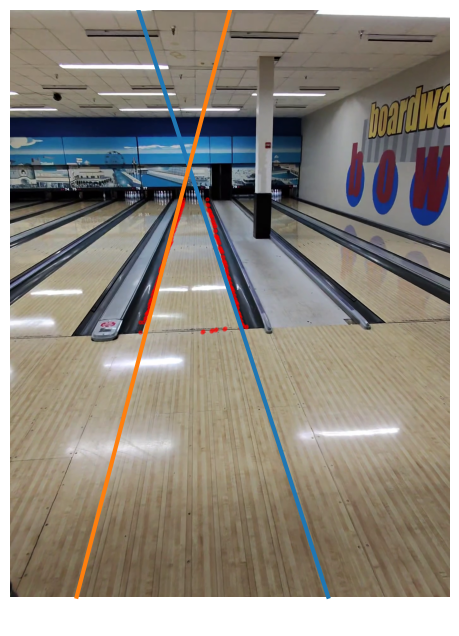